# Intro
Here nuclei segmentation from microscopic image was done using unet.We just used various augmentation technique like rotate,flip,shift & train by a Unet Network.The mean iou  was .524

In [1]:
import os
import sys
import random
import warnings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)

import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt


from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import cv2
import imutils





# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
TRAIN_PATH = 'D:/biomed project/stage1_train/'
TEST_PATH = 'D:/biomed project/just_test/'
rotation_range = [90, 270]

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

c:\users\abhijit\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Various augmentation technique

In [4]:
def rgbtogray(im):
    im_gray = rgb2gray(im)

    mask = im_gray
        
    return mask

In [23]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    
    print(shape)

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    img = rgbtogray(img)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:08<00:00,  5.23it/s]


Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.55it/s]


Done!


In [8]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    img = rgbtogray(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.89it/s]


Done!


In [9]:
# Defint preprocessing functions......

In [10]:
def rotation(img):
    img_total = []
    
    for i in rotation_range:
        
        rot =  imutils.rotate_bound(img, i)
        rot = resize(rot, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        img_total.append(rot)
        
       
     
    return img_total

In [11]:
#flip

In [12]:
def flip_vertical(img):
    a=img[:,:,0]
    #b=img[:,:,1]
    #c=img[:,:,2]
    
    
    
    av=cv2.flip(a,1)
        
    #bv=cv2.flip(b,1)
    
    #cv=cv2.flip(c,1)
        

    
    flipped = av
        
    return flipped
    
    

In [13]:
def flip_horizontal(img):
    a=img[:,:,0]
    #b=img[:,:,1]
    #c=img[:,:,2]
    
    ah = cv2.flip(a, 0)
    #bh = cv2.flip(b, 0)
    #ch = cv2.flip(c, 0)
    
    flipped = ah
    
    return flipped
    

In [18]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    rotated_images = []
    elastic_images = []
    
    for i in range(0,imgs.shape[0]):
        
        
        
        vflip = resize(flip_vertical(imgs[i, :, :, :]), (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        hflip = resize(flip_horizontal(imgs[i, :, :, :]), (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        
        rot = rotation(imgs[i, :, :, :])
        elastic = elastic_transform(imgs[i, :, :, :], imgs.shape[1] * 2, imgs.shape[1] * 0.08, imgs.shape[1] * 0.08)
        
        
        
        
    
        vert_flip_imgs.append(vflip)
        hori_flip_imgs.append(hflip)
        elastic_images.append(elastic)
        rotated_images.extend(rot)
    
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    r = np.array(rotated_images)
    e = np.array(elastic_images)
    
    v1 = v.reshape(670,128,128,1)
    h1 = h.reshape(670,128,128,1)
    e1 = e.reshape(670, 128, 128, 1)
    r = np.expand_dims(r, axis=-1)
    r1 = r.reshape(1340,128,128,1)
    
    
    
    print(imgs.shape)
    print(v1.shape)
    print(h1.shape)
    print(r1.shape)
    
    more_images = np.concatenate((imgs,v1,h1,r1, e1))
    
    return more_images

def duplicate_labels(labels):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    rotated_images = []
    elastic_images = []
    for i in range(0,labels.shape[0]):
        a=labels[i,:,:,0]
        a = np.array(a, dtype=np.uint8 )
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        ar=rotation(a)
        e = elastic_transform(labels[i, :, :, 0])
        
        vert_flip_imgs.append(av.reshape(IMG_WIDTH,IMG_WIDTH,1))
        hori_flip_imgs.append(ah.reshape(IMG_WIDTH,IMG_WIDTH,1))
        elastic_images.append(e.reshape(IMG_WIDTH, IMG_WIDTH, 1))
        rotated_images.extend(ar)
        
    v = np.array(vert_flip_imgs)
    v1 = v.reshape(670,128,128,1)
    print(v1.shape)
    h = np.array(hori_flip_imgs)
    h1 = h.reshape(670,128,128,1)
    print(h1.shape)
    r = np.array(rotated_images)
    r = np.expand_dims(r, axis=-1)
    r1 = r.reshape(1340,128,128,1)
    print(r1.shape)
    et = np.array(elastic_images)
    e = et.reshape(670, 128, 128,1)
    
    

    
    duplicate_labels = np.concatenate((labels,v,h,r, e), axis=0)
    return duplicate_labels

Let's see if things look all right by drawing some random images and their associated masks.

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. 

In [14]:



def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [15]:
# Build U-Net model
IMG_CHANNELS = 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [16]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train_aug, Y_train_aug, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3015 samples, validate on 335 samples
Epoch 1/30
3015/3015 [==============================] - ETA: 2:46:21 - loss: 0.6931 - mean_iou: 0.0000e+0 - ETA: 55:17 - loss: 0.6908 - mean_iou: 0.0038      - ETA: 27:29 - loss: 0.6856 - mean_iou: 0.002 - ETA: 20:32 - loss: 0.6807 - mean_iou: 0.002 - ETA: 16:22 - loss: 0.6735 - mean_iou: 0.002 - ETA: 12:31 - loss: 0.6642 - mean_iou: 0.001 - ETA: 10:49 - loss: 0.6553 - mean_iou: 0.001 - ETA: 8:57 - loss: 0.6325 - mean_iou: 0.001 - ETA: 8:02 - loss: 0.6255 - mean_iou: 0.00 - ETA: 6:56 - loss: 0.6014 - mean_iou: 0.00 - ETA: 6:22 - loss: 0.5875 - mean_iou: 0.00 - ETA: 5:38 - loss: 0.5771 - mean_iou: 9.5947e- - ETA: 5:15 - loss: 0.5695 - mean_iou: 9.1001e- - ETA: 4:54 - loss: 0.5630 - mean_iou: 8.6573e- - ETA: 4:27 - loss: 0.5577 - mean_iou: 8.0723e- - ETA: 4:11 - loss: 0.5530 - mean_iou: 7.7256e- - ETA: 3:51 - loss: 0.5438 - mean_iou: 7.2618e- - ETA: 3:39 - loss: 0.5374 - mean_iou: 6.9848e- - ETA: 3:23 - loss: 0.5309 - mean_iou: 6.6098e- - ET

3015/3015 [==============================] - ETA: 8s - loss: 0.0479 - mean_iou: 0.20 - ETA: 9s - loss: 0.1153 - mean_iou: 0.20 - ETA: 9s - loss: 0.1354 - mean_iou: 0.20 - ETA: 8s - loss: 0.1257 - mean_iou: 0.20 - ETA: 8s - loss: 0.1244 - mean_iou: 0.20 - ETA: 8s - loss: 0.1242 - mean_iou: 0.20 - ETA: 8s - loss: 0.1197 - mean_iou: 0.20 - ETA: 8s - loss: 0.1152 - mean_iou: 0.20 - ETA: 8s - loss: 0.1197 - mean_iou: 0.20 - ETA: 8s - loss: 0.1195 - mean_iou: 0.20 - ETA: 8s - loss: 0.1194 - mean_iou: 0.20 - ETA: 8s - loss: 0.1180 - mean_iou: 0.20 - ETA: 8s - loss: 0.1224 - mean_iou: 0.20 - ETA: 8s - loss: 0.1221 - mean_iou: 0.20 - ETA: 8s - loss: 0.1245 - mean_iou: 0.20 - ETA: 8s - loss: 0.1240 - mean_iou: 0.21 - ETA: 8s - loss: 0.1230 - mean_iou: 0.21 - ETA: 8s - loss: 0.1207 - mean_iou: 0.21 - ETA: 8s - loss: 0.1210 - mean_iou: 0.21 - ETA: 8s - loss: 0.1206 - mean_iou: 0.21 - ETA: 8s - loss: 0.1209 - mean_iou: 0.21 - ETA: 7s - loss: 0.1230 - mean_iou: 0.21 - ETA: 7s - loss: 0.1233 - mean_i

3015/3015 [==============================] - ETA: 8s - loss: 0.0916 - mean_iou: 0.26 - ETA: 8s - loss: 0.1288 - mean_iou: 0.26 - ETA: 8s - loss: 0.1318 - mean_iou: 0.26 - ETA: 8s - loss: 0.1435 - mean_iou: 0.26 - ETA: 8s - loss: 0.1391 - mean_iou: 0.26 - ETA: 8s - loss: 0.1354 - mean_iou: 0.26 - ETA: 8s - loss: 0.1301 - mean_iou: 0.26 - ETA: 8s - loss: 0.1275 - mean_iou: 0.26 - ETA: 8s - loss: 0.1214 - mean_iou: 0.26 - ETA: 8s - loss: 0.1264 - mean_iou: 0.26 - ETA: 8s - loss: 0.1265 - mean_iou: 0.26 - ETA: 8s - loss: 0.1228 - mean_iou: 0.26 - ETA: 8s - loss: 0.1219 - mean_iou: 0.26 - ETA: 8s - loss: 0.1245 - mean_iou: 0.26 - ETA: 8s - loss: 0.1260 - mean_iou: 0.26 - ETA: 7s - loss: 0.1269 - mean_iou: 0.26 - ETA: 8s - loss: 0.1265 - mean_iou: 0.26 - ETA: 7s - loss: 0.1257 - mean_iou: 0.26 - ETA: 7s - loss: 0.1330 - mean_iou: 0.26 - ETA: 7s - loss: 0.1326 - mean_iou: 0.26 - ETA: 7s - loss: 0.1326 - mean_iou: 0.26 - ETA: 7s - loss: 0.1338 - mean_iou: 0.26 - ETA: 7s - loss: 0.1338 - mean_i

3015/3015 [==============================] - ETA: 10s - loss: 0.1267 - mean_iou: 0.289 - ETA: 8s - loss: 0.0897 - mean_iou: 0.289 - ETA: 8s - loss: 0.0948 - mean_iou: 0.28 - ETA: 8s - loss: 0.0975 - mean_iou: 0.28 - ETA: 8s - loss: 0.0938 - mean_iou: 0.28 - ETA: 8s - loss: 0.1182 - mean_iou: 0.28 - ETA: 8s - loss: 0.1212 - mean_iou: 0.28 - ETA: 8s - loss: 0.1232 - mean_iou: 0.28 - ETA: 8s - loss: 0.1232 - mean_iou: 0.28 - ETA: 8s - loss: 0.1214 - mean_iou: 0.28 - ETA: 8s - loss: 0.1212 - mean_iou: 0.28 - ETA: 8s - loss: 0.1235 - mean_iou: 0.28 - ETA: 8s - loss: 0.1254 - mean_iou: 0.28 - ETA: 8s - loss: 0.1256 - mean_iou: 0.28 - ETA: 8s - loss: 0.1230 - mean_iou: 0.28 - ETA: 7s - loss: 0.1245 - mean_iou: 0.28 - ETA: 7s - loss: 0.1232 - mean_iou: 0.28 - ETA: 7s - loss: 0.1240 - mean_iou: 0.28 - ETA: 7s - loss: 0.1243 - mean_iou: 0.28 - ETA: 7s - loss: 0.1236 - mean_iou: 0.28 - ETA: 7s - loss: 0.1217 - mean_iou: 0.28 - ETA: 7s - loss: 0.1206 - mean_iou: 0.28 - ETA: 7s - loss: 0.1203 - mea

3015/3015 [==============================] - ETA: 9s - loss: 0.0995 - mean_iou: 0.30 - ETA: 8s - loss: 0.1083 - mean_iou: 0.30 - ETA: 7s - loss: 0.1167 - mean_iou: 0.30 - ETA: 8s - loss: 0.1225 - mean_iou: 0.30 - ETA: 8s - loss: 0.1252 - mean_iou: 0.30 - ETA: 8s - loss: 0.1331 - mean_iou: 0.30 - ETA: 8s - loss: 0.1246 - mean_iou: 0.30 - ETA: 8s - loss: 0.1248 - mean_iou: 0.30 - ETA: 8s - loss: 0.1209 - mean_iou: 0.30 - ETA: 8s - loss: 0.1196 - mean_iou: 0.30 - ETA: 8s - loss: 0.1183 - mean_iou: 0.30 - ETA: 8s - loss: 0.1164 - mean_iou: 0.30 - ETA: 8s - loss: 0.1197 - mean_iou: 0.30 - ETA: 7s - loss: 0.1233 - mean_iou: 0.30 - ETA: 8s - loss: 0.1241 - mean_iou: 0.30 - ETA: 7s - loss: 0.1214 - mean_iou: 0.30 - ETA: 7s - loss: 0.1243 - mean_iou: 0.30 - ETA: 7s - loss: 0.1228 - mean_iou: 0.30 - ETA: 7s - loss: 0.1225 - mean_iou: 0.30 - ETA: 7s - loss: 0.1228 - mean_iou: 0.30 - ETA: 7s - loss: 0.1225 - mean_iou: 0.30 - ETA: 7s - loss: 0.1239 - mean_iou: 0.30 - ETA: 7s - loss: 0.1245 - mean_i

3015/3015 [==============================] - ETA: 8s - loss: 0.1273 - mean_iou: 0.30 - ETA: 8s - loss: 0.1177 - mean_iou: 0.30 - ETA: 8s - loss: 0.1124 - mean_iou: 0.30 - ETA: 8s - loss: 0.1159 - mean_iou: 0.30 - ETA: 8s - loss: 0.1097 - mean_iou: 0.30 - ETA: 8s - loss: 0.1172 - mean_iou: 0.30 - ETA: 8s - loss: 0.1234 - mean_iou: 0.30 - ETA: 8s - loss: 0.1161 - mean_iou: 0.30 - ETA: 8s - loss: 0.1184 - mean_iou: 0.30 - ETA: 8s - loss: 0.1150 - mean_iou: 0.30 - ETA: 8s - loss: 0.1165 - mean_iou: 0.30 - ETA: 8s - loss: 0.1237 - mean_iou: 0.30 - ETA: 8s - loss: 0.1241 - mean_iou: 0.30 - ETA: 8s - loss: 0.1258 - mean_iou: 0.30 - ETA: 8s - loss: 0.1258 - mean_iou: 0.30 - ETA: 8s - loss: 0.1276 - mean_iou: 0.30 - ETA: 8s - loss: 0.1250 - mean_iou: 0.30 - ETA: 7s - loss: 0.1238 - mean_iou: 0.30 - ETA: 7s - loss: 0.1233 - mean_iou: 0.30 - ETA: 7s - loss: 0.1231 - mean_iou: 0.30 - ETA: 7s - loss: 0.1226 - mean_iou: 0.30 - ETA: 7s - loss: 0.1236 - mean_iou: 0.30 - ETA: 7s - loss: 0.1209 - mean_i

3015/3015 [==============================] - ETA: 8s - loss: 0.1276 - mean_iou: 0.31 - ETA: 9s - loss: 0.0845 - mean_iou: 0.31 - ETA: 9s - loss: 0.0995 - mean_iou: 0.31 - ETA: 9s - loss: 0.1001 - mean_iou: 0.31 - ETA: 8s - loss: 0.1031 - mean_iou: 0.31 - ETA: 8s - loss: 0.1101 - mean_iou: 0.31 - ETA: 8s - loss: 0.1093 - mean_iou: 0.31 - ETA: 8s - loss: 0.1048 - mean_iou: 0.31 - ETA: 8s - loss: 0.1033 - mean_iou: 0.31 - ETA: 8s - loss: 0.0981 - mean_iou: 0.31 - ETA: 8s - loss: 0.0999 - mean_iou: 0.31 - ETA: 8s - loss: 0.0984 - mean_iou: 0.31 - ETA: 8s - loss: 0.1020 - mean_iou: 0.31 - ETA: 8s - loss: 0.1015 - mean_iou: 0.31 - ETA: 8s - loss: 0.1003 - mean_iou: 0.31 - ETA: 8s - loss: 0.1008 - mean_iou: 0.31 - ETA: 8s - loss: 0.1045 - mean_iou: 0.31 - ETA: 8s - loss: 0.1080 - mean_iou: 0.31 - ETA: 7s - loss: 0.1098 - mean_iou: 0.31 - ETA: 7s - loss: 0.1101 - mean_iou: 0.31 - ETA: 7s - loss: 0.1100 - mean_iou: 0.31 - ETA: 7s - loss: 0.1120 - mean_iou: 0.31 - ETA: 7s - loss: 0.1119 - mean_i

3015/3015 [==============================] - ETA: 9s - loss: 0.0848 - mean_iou: 0.31 - ETA: 8s - loss: 0.0892 - mean_iou: 0.31 - ETA: 8s - loss: 0.0933 - mean_iou: 0.31 - ETA: 8s - loss: 0.1058 - mean_iou: 0.31 - ETA: 8s - loss: 0.1026 - mean_iou: 0.31 - ETA: 8s - loss: 0.1101 - mean_iou: 0.31 - ETA: 8s - loss: 0.1147 - mean_iou: 0.31 - ETA: 8s - loss: 0.1153 - mean_iou: 0.31 - ETA: 8s - loss: 0.1121 - mean_iou: 0.31 - ETA: 8s - loss: 0.1113 - mean_iou: 0.31 - ETA: 8s - loss: 0.1126 - mean_iou: 0.31 - ETA: 8s - loss: 0.1126 - mean_iou: 0.31 - ETA: 8s - loss: 0.1122 - mean_iou: 0.31 - ETA: 8s - loss: 0.1119 - mean_iou: 0.31 - ETA: 8s - loss: 0.1100 - mean_iou: 0.31 - ETA: 8s - loss: 0.1111 - mean_iou: 0.31 - ETA: 8s - loss: 0.1120 - mean_iou: 0.31 - ETA: 7s - loss: 0.1099 - mean_iou: 0.31 - ETA: 7s - loss: 0.1116 - mean_iou: 0.31 - ETA: 7s - loss: 0.1110 - mean_iou: 0.31 - ETA: 7s - loss: 0.1114 - mean_iou: 0.31 - ETA: 7s - loss: 0.1101 - mean_iou: 0.31 - ETA: 7s - loss: 0.1153 - mean_i

3015/3015 [==============================] - ETA: 10s - loss: 0.0901 - mean_iou: 0.323 - ETA: 9s - loss: 0.1815 - mean_iou: 0.323 - ETA: 9s - loss: 0.1498 - mean_iou: 0.32 - ETA: 9s - loss: 0.1405 - mean_iou: 0.32 - ETA: 9s - loss: 0.1384 - mean_iou: 0.32 - ETA: 9s - loss: 0.1255 - mean_iou: 0.32 - ETA: 9s - loss: 0.1187 - mean_iou: 0.32 - ETA: 8s - loss: 0.1212 - mean_iou: 0.32 - ETA: 8s - loss: 0.1225 - mean_iou: 0.32 - ETA: 8s - loss: 0.1294 - mean_iou: 0.32 - ETA: 8s - loss: 0.1310 - mean_iou: 0.32 - ETA: 8s - loss: 0.1302 - mean_iou: 0.32 - ETA: 8s - loss: 0.1317 - mean_iou: 0.32 - ETA: 8s - loss: 0.1313 - mean_iou: 0.32 - ETA: 8s - loss: 0.1266 - mean_iou: 0.32 - ETA: 8s - loss: 0.1276 - mean_iou: 0.32 - ETA: 8s - loss: 0.1249 - mean_iou: 0.32 - ETA: 8s - loss: 0.1216 - mean_iou: 0.32 - ETA: 7s - loss: 0.1199 - mean_iou: 0.32 - ETA: 7s - loss: 0.1191 - mean_iou: 0.32 - ETA: 7s - loss: 0.1197 - mean_iou: 0.32 - ETA: 7s - loss: 0.1207 - mean_iou: 0.32 - ETA: 7s - loss: 0.1208 - mea

3015/3015 [==============================] - ETA: 11s - loss: 0.1293 - mean_iou: 0.326 - ETA: 8s - loss: 0.1154 - mean_iou: 0.326 - ETA: 9s - loss: 0.1362 - mean_iou: 0.32 - ETA: 8s - loss: 0.1252 - mean_iou: 0.32 - ETA: 8s - loss: 0.1223 - mean_iou: 0.32 - ETA: 8s - loss: 0.1462 - mean_iou: 0.32 - ETA: 8s - loss: 0.1553 - mean_iou: 0.32 - ETA: 8s - loss: 0.1549 - mean_iou: 0.32 - ETA: 8s - loss: 0.1521 - mean_iou: 0.32 - ETA: 8s - loss: 0.1550 - mean_iou: 0.32 - ETA: 8s - loss: 0.1494 - mean_iou: 0.32 - ETA: 8s - loss: 0.1459 - mean_iou: 0.32 - ETA: 8s - loss: 0.1436 - mean_iou: 0.32 - ETA: 8s - loss: 0.1381 - mean_iou: 0.32 - ETA: 8s - loss: 0.1369 - mean_iou: 0.32 - ETA: 7s - loss: 0.1343 - mean_iou: 0.32 - ETA: 7s - loss: 0.1398 - mean_iou: 0.32 - ETA: 7s - loss: 0.1389 - mean_iou: 0.32 - ETA: 7s - loss: 0.1374 - mean_iou: 0.32 - ETA: 7s - loss: 0.1353 - mean_iou: 0.32 - ETA: 7s - loss: 0.1336 - mean_iou: 0.32 - ETA: 7s - loss: 0.1322 - mean_iou: 0.32 - ETA: 7s - loss: 0.1316 - mea

3015/3015 [==============================] - ETA: 8s - loss: 0.2592 - mean_iou: 0.32 - ETA: 7s - loss: 0.1371 - mean_iou: 0.32 - ETA: 8s - loss: 0.1720 - mean_iou: 0.32 - ETA: 8s - loss: 0.1542 - mean_iou: 0.32 - ETA: 8s - loss: 0.1478 - mean_iou: 0.32 - ETA: 8s - loss: 0.1365 - mean_iou: 0.32 - ETA: 8s - loss: 0.1366 - mean_iou: 0.32 - ETA: 8s - loss: 0.1299 - mean_iou: 0.32 - ETA: 8s - loss: 0.1283 - mean_iou: 0.32 - ETA: 8s - loss: 0.1302 - mean_iou: 0.32 - ETA: 8s - loss: 0.1276 - mean_iou: 0.32 - ETA: 8s - loss: 0.1281 - mean_iou: 0.32 - ETA: 8s - loss: 0.1262 - mean_iou: 0.32 - ETA: 8s - loss: 0.1251 - mean_iou: 0.32 - ETA: 7s - loss: 0.1288 - mean_iou: 0.32 - ETA: 7s - loss: 0.1281 - mean_iou: 0.32 - ETA: 7s - loss: 0.1276 - mean_iou: 0.32 - ETA: 7s - loss: 0.1285 - mean_iou: 0.32 - ETA: 7s - loss: 0.1267 - mean_iou: 0.32 - ETA: 7s - loss: 0.1268 - mean_iou: 0.32 - ETA: 7s - loss: 0.1252 - mean_iou: 0.32 - ETA: 7s - loss: 0.1279 - mean_iou: 0.32 - ETA: 7s - loss: 0.1278 - mean_i

3015/3015 [==============================] - ETA: 9s - loss: 0.0912 - mean_iou: 0.33 - ETA: 8s - loss: 0.0946 - mean_iou: 0.33 - ETA: 8s - loss: 0.0926 - mean_iou: 0.33 - ETA: 8s - loss: 0.0970 - mean_iou: 0.33 - ETA: 8s - loss: 0.0893 - mean_iou: 0.33 - ETA: 8s - loss: 0.0824 - mean_iou: 0.33 - ETA: 8s - loss: 0.0863 - mean_iou: 0.33 - ETA: 8s - loss: 0.0888 - mean_iou: 0.33 - ETA: 8s - loss: 0.0905 - mean_iou: 0.33 - ETA: 8s - loss: 0.0888 - mean_iou: 0.33 - ETA: 8s - loss: 0.0884 - mean_iou: 0.33 - ETA: 7s - loss: 0.0864 - mean_iou: 0.33 - ETA: 7s - loss: 0.0874 - mean_iou: 0.33 - ETA: 7s - loss: 0.0870 - mean_iou: 0.33 - ETA: 7s - loss: 0.0891 - mean_iou: 0.33 - ETA: 7s - loss: 0.0902 - mean_iou: 0.33 - ETA: 7s - loss: 0.0923 - mean_iou: 0.33 - ETA: 7s - loss: 0.0921 - mean_iou: 0.33 - ETA: 7s - loss: 0.0902 - mean_iou: 0.33 - ETA: 7s - loss: 0.0913 - mean_iou: 0.33 - ETA: 7s - loss: 0.0969 - mean_iou: 0.33 - ETA: 7s - loss: 0.0978 - mean_iou: 0.33 - ETA: 7s - loss: 0.0979 - mean_i

3015/3015 [==============================] - ETA: 9s - loss: 0.1097 - mean_iou: 0.33 - ETA: 8s - loss: 0.1072 - mean_iou: 0.33 - ETA: 8s - loss: 0.1135 - mean_iou: 0.33 - ETA: 8s - loss: 0.1205 - mean_iou: 0.33 - ETA: 8s - loss: 0.1194 - mean_iou: 0.33 - ETA: 8s - loss: 0.1142 - mean_iou: 0.33 - ETA: 8s - loss: 0.1119 - mean_iou: 0.33 - ETA: 8s - loss: 0.1105 - mean_iou: 0.33 - ETA: 8s - loss: 0.1078 - mean_iou: 0.33 - ETA: 8s - loss: 0.1070 - mean_iou: 0.33 - ETA: 8s - loss: 0.1078 - mean_iou: 0.33 - ETA: 8s - loss: 0.1076 - mean_iou: 0.33 - ETA: 8s - loss: 0.1070 - mean_iou: 0.33 - ETA: 8s - loss: 0.1060 - mean_iou: 0.33 - ETA: 8s - loss: 0.1047 - mean_iou: 0.33 - ETA: 7s - loss: 0.1059 - mean_iou: 0.33 - ETA: 8s - loss: 0.1048 - mean_iou: 0.33 - ETA: 7s - loss: 0.1050 - mean_iou: 0.33 - ETA: 7s - loss: 0.1055 - mean_iou: 0.33 - ETA: 7s - loss: 0.1057 - mean_iou: 0.33 - ETA: 7s - loss: 0.1067 - mean_iou: 0.33 - ETA: 7s - loss: 0.1071 - mean_iou: 0.33 - ETA: 7s - loss: 0.1069 - mean_i

3015/3015 [==============================] - ETA: 8s - loss: 0.0873 - mean_iou: 0.33 - ETA: 8s - loss: 0.0918 - mean_iou: 0.33 - ETA: 7s - loss: 0.0944 - mean_iou: 0.33 - ETA: 8s - loss: 0.0984 - mean_iou: 0.33 - ETA: 8s - loss: 0.1029 - mean_iou: 0.33 - ETA: 8s - loss: 0.1078 - mean_iou: 0.33 - ETA: 8s - loss: 0.1044 - mean_iou: 0.33 - ETA: 8s - loss: 0.1039 - mean_iou: 0.33 - ETA: 8s - loss: 0.1038 - mean_iou: 0.33 - ETA: 8s - loss: 0.1061 - mean_iou: 0.33 - ETA: 8s - loss: 0.1084 - mean_iou: 0.33 - ETA: 7s - loss: 0.1097 - mean_iou: 0.33 - ETA: 7s - loss: 0.1143 - mean_iou: 0.33 - ETA: 7s - loss: 0.1113 - mean_iou: 0.33 - ETA: 7s - loss: 0.1104 - mean_iou: 0.33 - ETA: 7s - loss: 0.1097 - mean_iou: 0.33 - ETA: 7s - loss: 0.1089 - mean_iou: 0.33 - ETA: 7s - loss: 0.1073 - mean_iou: 0.33 - ETA: 7s - loss: 0.1072 - mean_iou: 0.33 - ETA: 7s - loss: 0.1060 - mean_iou: 0.33 - ETA: 7s - loss: 0.1062 - mean_iou: 0.33 - ETA: 7s - loss: 0.1085 - mean_iou: 0.33 - ETA: 7s - loss: 0.1076 - mean_i

3015/3015 [==============================] - ETA: 12s - loss: 0.0841 - mean_iou: 0.338 - ETA: 8s - loss: 0.0891 - mean_iou: 0.338 - ETA: 9s - loss: 0.0843 - mean_iou: 0.33 - ETA: 8s - loss: 0.0790 - mean_iou: 0.33 - ETA: 8s - loss: 0.0842 - mean_iou: 0.33 - ETA: 8s - loss: 0.0849 - mean_iou: 0.33 - ETA: 8s - loss: 0.0844 - mean_iou: 0.33 - ETA: 8s - loss: 0.0858 - mean_iou: 0.33 - ETA: 8s - loss: 0.0890 - mean_iou: 0.33 - ETA: 8s - loss: 0.0890 - mean_iou: 0.33 - ETA: 8s - loss: 0.0880 - mean_iou: 0.33 - ETA: 8s - loss: 0.0892 - mean_iou: 0.33 - ETA: 8s - loss: 0.0917 - mean_iou: 0.33 - ETA: 8s - loss: 0.0912 - mean_iou: 0.33 - ETA: 8s - loss: 0.0934 - mean_iou: 0.33 - ETA: 8s - loss: 0.0944 - mean_iou: 0.33 - ETA: 8s - loss: 0.0931 - mean_iou: 0.33 - ETA: 8s - loss: 0.0933 - mean_iou: 0.33 - ETA: 8s - loss: 0.0928 - mean_iou: 0.33 - ETA: 8s - loss: 0.0927 - mean_iou: 0.33 - ETA: 8s - loss: 0.0931 - mean_iou: 0.33 - ETA: 7s - loss: 0.0928 - mean_iou: 0.33 - ETA: 7s - loss: 0.0926 - mea

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [36]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = model.predict(X_train_aug[:int(X_train.shape[0]*0.9)], verbose=1)


#preds_val = model.predict(X_train_aug[int(X_train.shape[0]*0.9):], verbose=1)

preds_test = model.predict(X_test, verbose=1)




# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
#for i in range(len(preds_test)):
    #preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

5/5 [==============================] - 52s 10s/step


In [37]:
X_test.shape

(5, 128, 128, 1)

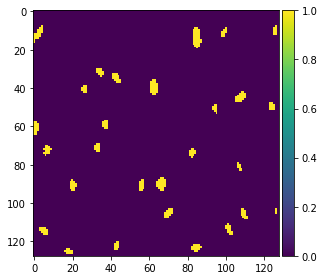

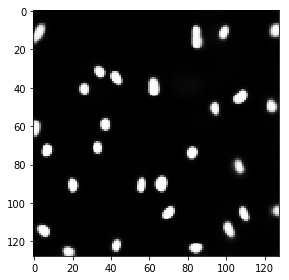

In [41]:
# Perform a sanity check on some random training samples
#ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_test[1]))
plt.show()
#imshow(np.squeeze(Y_train[ix]))
#plt.show()
imshow(np.squeeze(preds_test[1]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [45]:
preds_test[0]

array([[[0.08786522],
        [0.05686973],
        [0.03751799],
        ...,
        [0.02683526],
        [0.03033149],
        [0.06877642]],

       [[0.04712997],
        [0.02856636],
        [0.0175721 ],
        ...,
        [0.01289165],
        [0.01263478],
        [0.03222051]],

       [[0.02696483],
        [0.01600611],
        [0.01028741],
        ...,
        [0.01394046],
        [0.01247264],
        [0.03169761]],

       ...,

       [[0.01276599],
        [0.00661415],
        [0.0070248 ],
        ...,
        [0.01157845],
        [0.01522437],
        [0.0272772 ]],

       [[0.01737915],
        [0.00596924],
        [0.00731496],
        ...,
        [0.00948024],
        [0.01899255],
        [0.03512467]],

       [[0.04869918],
        [0.01473733],
        [0.01181994],
        ...,
        [0.01309168],
        [0.02122344],
        [0.04830367]]], dtype=float32)

In [33]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

IndexError: index 1806 is out of bounds for axis 0 with size 67

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results



In [ ]:

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    print(new_test_ids)

... and then finally create our submission!

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./sub-dsbowl2018-1.csv', index=False)